## Load libraries

In [ ]:
!pip install comet_ml

In [ ]:
from comet_ml import Experiment

In [ ]:
experiment = Experiment(#api_key=YOUR API KEY HERE, project_name='', workspace='')

In [ ]:
#MOVE THIS CELL WHERE APPROPRIATE
#Check "Comet starter notebook" preprocessing for more info
#Remember to save new parameters and metrics in a dictionary for logging
#params = {}
#metrics = {}

#Log parameters and results
#experiment.log_parameters(params)
#experiment.log_metrics(metrics)

In [ ]:
#MOVE THIS CELL WHERE APPROPRIATE
#Check "Comet starter notebook" preprocessing for more info
#experiment.end()

In [1]:
import numpy as np
import pandas as pd
import spacy
import re
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\piala\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
nlp = spacy.load('en_core_web_lg')

In [3]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\piala\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [4]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [5]:
import wordcloud

In [6]:
from wordcloud import WordCloud

In [ ]:
!pip install textblob

In [ ]:
from textblob import TextBlob

## Load data

In [7]:
df = pd.read_csv('data/train.csv')

In [75]:
#More details on rows and columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13729 entries, 0 to 15818
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sentiment          13729 non-null  int64  
 1   message            13729 non-null  object 
 2   tweetid            13729 non-null  int64  
 3   raw_data           13729 non-null  object 
 4   msg_removed_stops  13729 non-null  object 
 5   length             13729 non-null  int64  
 6   compound           13729 non-null  float64
dtypes: float64(1), int64(3), object(3)
memory usage: 1.5+ MB


In [76]:
df.set_index('tweetid', inplace=True)

In [8]:
df['raw_data'] = df['message']

## Data preprocessing

In [ ]:
#Things to consider:
#Remove 'RT ', '@___:', '#', 'urls'
#How does spelling affect the analysis?

In [9]:
print(len(df))
print(len(set(df['message'])))
print(df.isna().sum())

15819
14229
sentiment    0
message      0
tweetid      0
raw_data     0
dtype: int64


In [10]:
#Remove spaces after hashtags
for i in range(len(df)):
    for j in re.finditer('# ', df.iloc[i, 1]):
        if j.span() is not None:
            df.iloc[i, 1] = re.sub(df.iloc[i, 1][j.span()[0]:j.span()[1]], r'#', df.iloc[i, 1])
df.head()

,sentiment,message,tweetid,raw_data
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,PolySciMajor EPA chief doesn't think carbon di...
1,1,It's not like we lack evidence of anthropogeni...,126103,It's not like we lack evidence of anthropogeni...
2,2,RT @RawStory: Researchers say we have three ye...,698562,RT @RawStory: Researchers say we have three ye...
3,1,#TodayinMaker#WIRED : 2016 was a pivotal year ...,573736,#TodayinMaker# WIRED : 2016 was a pivotal year...
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,"RT @SoyNovioDeTodas: It's 2016, and a racist, ..."


In [11]:
#Remove hashtags, mentions and urls
regex_pattern = ['RT', '#[\w]*', '@[\w]*:', '@[\w]*', '((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*']
for i in range(len(df)):
    for j in range(len(regex_pattern)):
        for k in re.finditer(regex_pattern[j], df.iloc[i, 1]):
            if k.span() is not None:
                df.iloc[i, 1] = re.sub(k.group().strip(), '', df.iloc[i, 1])

In [12]:
#Reduce strings of repeated letters down to 2 eg looooooooove becomes loove (easier to correct later)
for i in range(len(df)):
    df.iloc[i, 1] = re.sub(r'([a-z])\1+', r'\1\1', df.iloc[i, 1])
    df.iloc[i, 1] = re.sub(r':', r'', df.iloc[i, 1])

In [13]:
#Remove html tags from messages
from io import StringIO
from html.parser import HTMLParser

class MLStripper(HTMLParser):
    def __init__(self):
        super().__init__()
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.text = StringIO()
    def handle_data(self, d):
        self.text.write(d)
    def get_data(self):
        return self.text.getvalue()

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

In [14]:
for i in range(len(df['message'])):
    df.iloc[i, 1] = strip_tags(df.iloc[i, 1])

In [15]:
#Drop duplicate tweets
df = df.drop_duplicates(['message'])
print(len(df))
print(len(set(df['message'])))

13729
13729


In [34]:
#Correct spelling in tweets as far as possible. Slang words are addressed in subsequent section.
for i in range(len(df)):
    b = TextBlob(df.iloc[i, 1])
    df.iloc[i, 1] = str(b.correct())
print("Complete")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

3498
3499
3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697


6774
6775
6776
6777
6778
6779
6780
6781
6782
6783
6784
6785
6786
6787
6788
6789
6790
6791
6792
6793
6794
6795
6796
6797
6798
6799
6800
6801
6802
6803
6804
6805
6806
6807
6808
6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973


10042
10043
10044
10045
10046
10047
10048
10049
10050
10051
10052
10053
10054
10055
10056
10057
10058
10059
10060
10061
10062
10063
10064
10065
10066
10067
10068
10069
10070
10071
10072
10073
10074
10075
10076
10077
10078
10079
10080
10081
10082
10083
10084
10085
10086
10087
10088
10089
10090
10091
10092
10093
10094
10095
10096
10097
10098
10099
10100
10101
10102
10103
10104
10105
10106
10107
10108
10109
10110
10111
10112
10113
10114
10115
10116
10117
10118
10119
10120
10121
10122
10123
10124
10125
10126
10127
10128
10129
10130
10131
10132
10133
10134
10135
10136
10137
10138
10139
10140
10141
10142
10143
10144
10145
10146
10147
10148
10149
10150
10151
10152
10153
10154
10155
10156
10157
10158
10159
10160
10161
10162
10163
10164
10165
10166
10167
10168
10169
10170
10171
10172
10173
10174
10175
10176
10177
10178
10179
10180
10181
10182
10183
10184
10185
10186
10187
10188
10189
10190
10191
10192
10193
10194
10195
10196
10197
10198
10199
10200
10201
10202
10203
10204
10205
10206
10207
1020

12772
12773
12774
12775
12776
12777
12778
12779
12780
12781
12782
12783
12784
12785
12786
12787
12788
12789
12790
12791
12792
12793
12794
12795
12796
12797
12798
12799
12800
12801
12802
12803
12804
12805
12806
12807
12808
12809
12810
12811
12812
12813
12814
12815
12816
12817
12818
12819
12820
12821
12822
12823
12824
12825
12826
12827
12828
12829
12830
12831
12832
12833
12834
12835
12836
12837
12838
12839
12840
12841
12842
12843
12844
12845
12846
12847
12848
12849
12850
12851
12852
12853
12854
12855
12856
12857
12858
12859
12860
12861
12862
12863
12864
12865
12866
12867
12868
12869
12870
12871
12872
12873
12874
12875
12876
12877
12878
12879
12880
12881
12882
12883
12884
12885
12886
12887
12888
12889
12890
12891
12892
12893
12894
12895
12896
12897
12898
12899
12900
12901
12902
12903
12904
12905
12906
12907
12908
12909
12910
12911
12912
12913
12914
12915
12916
12917
12918
12919
12920
12921
12922
12923
12924
12925
12926
12927
12928
12929
12930
12931
12932
12933
12934
12935
12936
12937
1293

In [35]:
#Remove stop words from messages.
df['msg_removed_stops'] = df['message']
df['msg_removed_stops'] = df['message'].apply(lambda x: ' '.join([item for item in x.split() if item.lower() not in nlp.Defaults.stop_words]))
df.head(10)

,sentiment,message,tweetid,raw_data,msg_removed_stops
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,PolySciMajor EPA chief doesn't think carbon di...,PolySciMajor EPA chief doesn't think carbon di...
1,1,It's not like we lack evidence of anthropogeni...,126103,It's not like we lack evidence of anthropogeni...,It's like lack evidence anthropogenic global w...
2,2,Researches say we have three years to act on...,698562,RT @RawStory: Researchers say we have three ye...,Researches years act climate change it’s late …
3,1,2016 was a pivotal year in the war on climat...,573736,#TodayinMaker# WIRED : 2016 was a pivotal year...,2016 pivotal year war climate change
4,1,"It's 2016, and a racism, exist, climate chan...",466954,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...","It's 2016, racism, exist, climate change denyi..."
5,1,North a read whether you do or don't believe i...,425577,Worth a read whether you do or don't believe i...,North read don't believe climate change
6,1,Like Hence doesn’t believe in global warming...,294933,RT @thenation: Mike Pence doesn’t believe in g...,Like doesn’t believe global warming smoking ca...
7,1,Six big things we can ALL do today to fight ...,992717,RT @makeandmendlife: Six big things we can ALL...,"big things today fight climate change, climate..."
8,1,By myo nephew is inconsolable. He wants to di...,664510,@AceofSpadesHQ My 8yo nephew is inconsolable. ...,myo nephew inconsolable. wants die old age lik...
9,1,no offense… but like… how do you just not be...,260471,RT @paigetweedy: no offense… but like… how do ...,offense… like… believe… global warming………


## Feature engineering

In [36]:
#Length of tweet
df['length'] = df['message'].apply(lambda i: len(i))

In [38]:
sid = SentimentIntensityAnalyzer()

In [39]:
#Add SlangSD dictionary to vader lexicon (Wu et al. (2016): http://arxiv.org/abs/1608.05129)
slang = pd.read_csv('SlangSD/SlangSD.txt', sep='\t', names=['word', 'score'])
slang_dict = dict(zip(slang['word'], slang['score']))
sid.lexicon.update(slang_dict)

In [73]:
#Sentiment analysis of cleaned tweets
df['compound']  = df['message'].apply(lambda review: sid.polarity_scores(review)).apply(lambda score_dict: score_dict['compound'])
df.head()

,sentiment,message,tweetid,raw_data,msg_removed_stops,length,compound
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,PolySciMajor EPA chief doesn't think carbon di...,PolySciMajor EPA chief doesn't think carbon di...,108,0.2261
1,1,It's not like we lack evidence of anthropogeni...,126103,It's not like we lack evidence of anthropogeni...,It's like lack evidence anthropogenic global w...,62,0.5109
2,2,Researches say we have three years to act on...,698562,RT @RawStory: Researchers say we have three ye...,Researches years act climate change it’s late …,85,-0.7184
3,1,2016 was a pivotal year in the war on climat...,573736,#TodayinMaker# WIRED : 2016 was a pivotal year...,2016 pivotal year war climate change,55,-0.2500
4,1,"It's 2016, and a racism, exist, climate chan...",466954,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...","It's 2016, racism, exist, climate change denyi...",88,-0.3400


## EDA

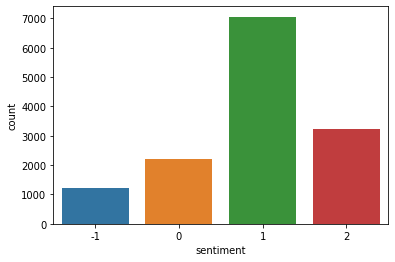

In [42]:
sns.countplot(df['sentiment'])
plt.show()

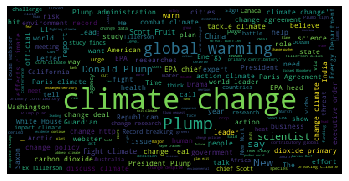

In [44]:
#Wordcloud of tweets
wordcloud = WordCloud().generate(' '.join(df[df['sentiment'] == 2]['msg_removed_stops']))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

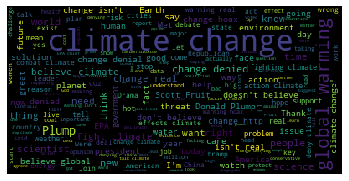

In [45]:
#Wordcloud of tweets
wordcloud = WordCloud().generate(' '.join(df[df['sentiment'] == 1]['msg_removed_stops']))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

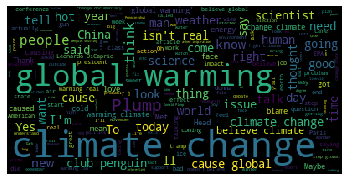

In [46]:
#Wordcloud of tweets
wordcloud = WordCloud().generate(' '.join(df[df['sentiment'] == 0]['msg_removed_stops']))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

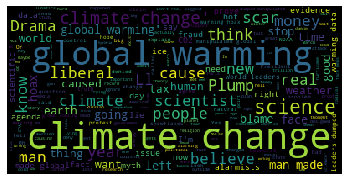

In [47]:
#Wordcloud of tweets
wordcloud = WordCloud().generate(' '.join(df[df['sentiment'] == -1]['msg_removed_stops']))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [48]:
def count_pos(df, sentiment):
    pos_dict = {}
    df_pos = df[df['sentiment'] == sentiment]
    for i in range(len(df_pos)):
        text = nlp(df.iloc[i, 1])
        for j in range(len(text)):
            part_of_speech = text[j].pos_
            if part_of_speech in pos_dict.keys():
                pos_dict[part_of_speech] += 1
            else:
                pos_dict[part_of_speech] = 1
    return pos_dict

In [49]:
def count_ent(df, sentiment):
    ent_dict = {}
    name_dict = {}
    df_pos = df[df['sentiment'] == sentiment]
    for i in range(len(df_pos)):
        text = nlp(df.iloc[i, 1])
        if text.ents:
            for ent in text.ents:
                if ent.label_ in ent_dict.keys():
                    ent_dict[ent.label_] += 1
                else:
                    ent_dict[ent.label_] = 1
            for ent in text.ents:
                if ent.text in name_dict.keys():
                    name_dict[ent.text] += 1
                else:
                    name_dict[ent.text] = 1
    return ent_dict, name_dict

In [50]:
grp_1_pos = count_pos(df, 1)
grp_2_pos = count_pos(df, 2)
grp_0_pos = count_pos(df, 0)
grp_neg1_pos = count_pos(df, -1)

In [51]:
grp_1_ent, name_1_ent = count_ent(df, 1)
grp_2_ent, name_2_ent = count_ent(df, 2)
grp_0_ent, name_0_ent = count_ent(df, 0)
grp_neg1_ent, name_neg1_ent = count_ent(df, -1)

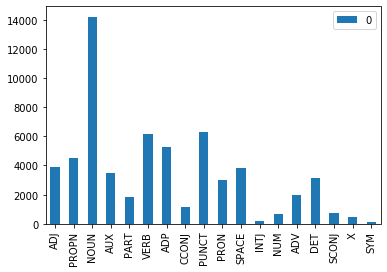

In [72]:
a = pd.DataFrame.from_dict(grp_2_pos, orient='index')
a.plot(kind='bar')
plt.show()

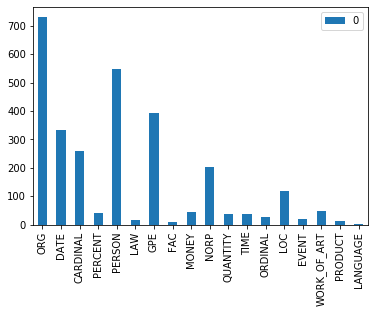

In [53]:
b = pd.DataFrame.from_dict(grp_2_ent, orient='index')
b.plot(kind='bar')
plt.show()

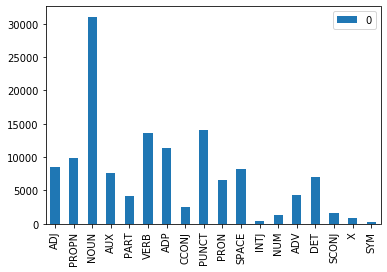

In [54]:
a = pd.DataFrame.from_dict(grp_1_pos, orient='index')
a.plot(kind='bar')
plt.show()

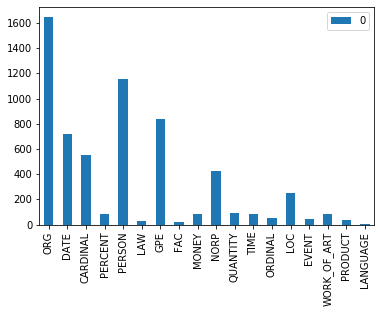

In [55]:
b = pd.DataFrame.from_dict(grp_1_ent, orient='index')
b.plot(kind='bar')
plt.show()

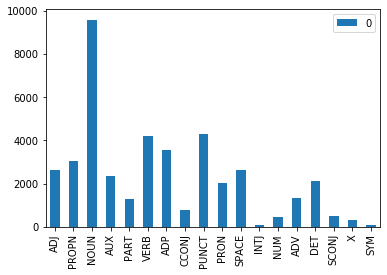

In [56]:
a = pd.DataFrame.from_dict(grp_0_pos, orient='index')
a.plot(kind='bar')
plt.show()

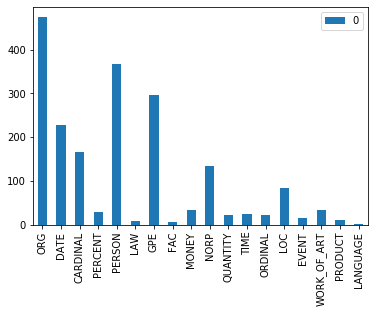

In [57]:
b = pd.DataFrame.from_dict(grp_0_ent, orient='index')
b.plot(kind='bar')
plt.show()

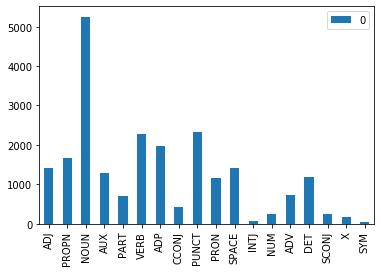

In [58]:
a = pd.DataFrame.from_dict(grp_neg1_pos, orient='index')
a.plot(kind='bar')
plt.show()

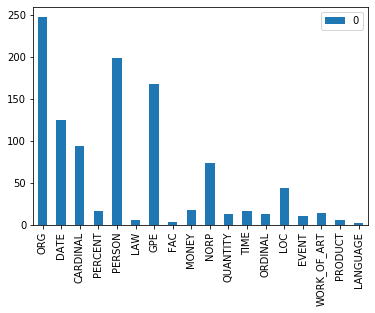

In [59]:
b = pd.DataFrame.from_dict(grp_neg1_ent, orient='index')
b.plot(kind='bar')
plt.show()

In [ ]:
# Checking the average words in a tweet
num_words = dftrain['message'].apply(lambda x: len(x.split()))
num_words_mean, num_words_std = np.mean(num_words), np.std(num_words)

# checking the average sentences in a tweet
num_sentences = dftrain['message'].apply(lambda x: len(re.split( '~ ...' ,'~'.join(x.split('.')))))
num_sentences_mean = np.mean(num_sentences)

## Data cleaning

In [61]:
#Imbalanced data
df['sentiment'].value_counts()

 1    7059
 2    3248
 0    2209
-1    1213
Name: sentiment, dtype: int64

In [62]:
#Balance Data
#Separate classes
sent_negative = df[df['sentiment']==-1]
sent_0 = df[df['sentiment']==0]
sent_1 = df[df['sentiment']==1]
sent_two = df[df['sentiment']==2]

In [63]:
#import module
from sklearn.utils import resample

In [64]:
#Resample to match sentiment 2's length

#Downsample majority
sent_one = resample(sent_1, replace=False, n_samples= len(df[df['sentiment']==2]), random_state=27) 

#Upsample minority
sent_zero = resample(sent_0, replace=True, n_samples= len(df[df['sentiment']==2]), random_state=27)
sent_neg = resample(sent_negative, replace=True, n_samples= len(df[df['sentiment']==2]), random_state=27)

#Join resampled classes back together
resampled = pd.concat([sent_one, sent_zero, sent_neg, sent_two])

In [65]:
#Balanced data
resampled['sentiment'].value_counts()

-1    3248
 2    3248
 1    3248
 0    3248
Name: sentiment, dtype: int64

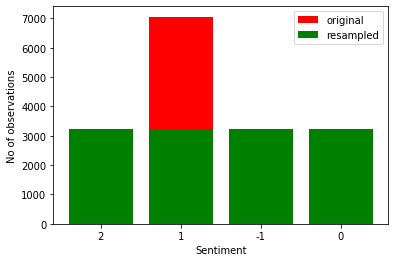

In [67]:
original_heights = [len(sent_negative), len(sent_0), len(sent_1), len(sent_two)]
resampled_heights = [len(sent_one),len(sent_two), len(sent_zero), len(sent_neg)]

labels = df['sentiment'].unique()
plt.bar(labels,original_heights,color='red')
plt.bar(labels,resampled_heights,color='green')
plt.xticks(labels,[-1, 0, 1, 2])
plt.ylabel("No of observations")
plt.xlabel('Sentiment')
plt.legend(['original','resampled'])
plt.show()

## Modelling

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
#X = 
#y = 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=50)

In [ ]:
from sklearn.linear_model import LogisticRegression

## Model evaluation

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
confusion_matrix(y_test, pred_lr)
labels = ['-1: Anti', '0: Neutral', '1: Pro', '2: News']

pd.DataFrame(data=confusion_matrix(y_test, pred_lr), index=labels, columns=labels)

In [ ]:
# Classification report
print('Classification Report')
print(classification_report(y_test, pred_lr, target_names=['-1: Anti', '0: Neutral', '1: Pro', '2: News']))